In [1]:
!pip install gradio opencv-python pytesseract deepface
!sudo apt install tesseract-ocr -y


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.4 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=2400304e91804aa5c79990502d1307df4a89fe4ee3c4df92927f510cd2768b1a
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [6]:
from IPython.display import display, Image as IPImage
import ipywidgets as widgets
from PIL import Image
import io


id_upload = widgets.FileUpload(accept='image/*', multiple=False, description='Upload ID Card')
selfie_upload = widgets.FileUpload(accept='image/*', multiple=False, description='Upload Selfie')


save_button = widgets.Button(description='Save Images')


output = widgets.Output()

def save_uploaded_images(btn):
    output.clear_output()
    if id_upload.value and selfie_upload.value:
        with output:
            try:
                # Extract and save ID image
                id_content = list(id_upload.value.values())[0]['content']
                id_image = Image.open(io.BytesIO(id_content)).convert("RGB")
                id_image.save("id.jpg")

                # Extract and save selfie image
                selfie_content = list(selfie_upload.value.values())[0]['content']
                selfie_image = Image.open(io.BytesIO(selfie_content)).convert("RGB")
                selfie_image.save("selfie.jpg")

                print("ID and Selfie successfully uploaded and saved as id.jpg and selfie.jpg")

            except Exception as e:
                print("Error saving images:", str(e))
    else:
        with output:
            print("Please upload both ID card and selfie.")


save_button.on_click(save_uploaded_images)


display(widgets.VBox([id_upload, selfie_upload, save_button, output]))


In [7]:
import pytesseract
import re
from PIL import Image

def extract_dob_from_saved_id():
    image = Image.open("id.jpg")
    text = pytesseract.image_to_string(image)
    print("🔍 Extracted Text from ID:", text)

    # Match format - DD/MM/YYYY
    dob_match = re.search(r'(\d{2}[-/]\d{2}[-/]\d{4})', text)
    if dob_match:
        return dob_match.group(1)

    # extracting the year
    year_match = re.search(r'\b(19|20)\d{2}\b', text)
    return year_match.group(0) if year_match else "DOB not found"

# Running the function on the saved image
dob = extract_dob_from_saved_id()
print(" Detected DOB:", dob)

🔍 Extracted Text from ID: aen ffs pos - 10/10/1989

Sakhi bai kushwah
| Female / =e
9826 6359 8852 "*

Wear - HA ses HT Ha

| wet ag areas

  

 Detected DOB: 10/10/1989


In [8]:
import cv2

def detect_and_crop_face(image_path="id.jpg", output_path="id_face.jpg"):

    image = cv2.imread(image_path)
    if image is None:
        print("❌ Image not found")
        return

    # Converting image  to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Using Haar cascade for robust face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    if len(faces) == 0:
        print("❌ No face detected.")
        return


    for (x, y, w, h) in faces:
        face = image[y:y+h, x:x+w]
        cv2.imwrite(output_path, face)
        print(f"Face detected and saved as {output_path}")
        return

# Run it
detect_and_crop_face()


✅ Face detected and saved as id_face.jpg


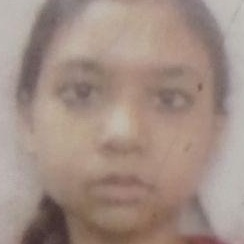

In [9]:
Image.open("id_face.jpg")


In [10]:
from deepface import DeepFace

result = DeepFace.verify(img1_path="id_face.jpg", img2_path="selfie.jpg")
print("Face Match Result:", result)


25-06-26 06:30:20 - Directory /root/.deepface has been created
25-06-26 06:30:20 - Directory /root/.deepface/weights has been created
25-06-26 06:30:22 - vgg_face_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/vgg_face_weights.h5
To: /root/.deepface/weights/vgg_face_weights.h5
100%|██████████| 580M/580M [00:04<00:00, 119MB/s] 


Face Match Result: {'verified': True, 'distance': 0.5595015222169184, 'threshold': 0.68, 'model': 'VGG-Face', 'detector_backend': 'opencv', 'similarity_metric': 'cosine', 'facial_areas': {'img1': {'x': 14, 'y': 9, 'w': 219, 'h': 219, 'left_eye': (168, 98), 'right_eye': (82, 91)}, 'img2': {'x': 98, 'y': 72, 'w': 239, 'h': 239, 'left_eye': (250, 159), 'right_eye': (168, 169)}}, 'time': 10.66}


In [11]:
from datetime import datetime

def calculate_age(dob_string):
    try:
        #parsing with DD/MM/YYYY format
        dob = datetime.strptime(dob_string, "%d/%m/%Y")
    except ValueError:
        try:

            dob = datetime.strptime(dob_string, "%d-%m-%Y")
        except ValueError:
             try:

                dob = datetime.strptime(dob_string, "%Y")
             except ValueError:

                 print(f" Could not parse DOB from string: {dob_string}")
                 return "N/A"


    today = datetime.today()

    age = today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))
    return age


age = calculate_age(dob)
print(f"Calculated Age: {age} years")

Calculated Age: 35 years


In [12]:
if result['verified'] and age >= 18:
    print(" User is verified and 18+")
elif not result['verified']:
    print(" Face does not match")
else:
    print("User is underage")


 User is verified and 18+
